# Median correction of the NSAF data table

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import AtlasAnalysisFunctions as AAF

In [11]:
def calc_median(row):
    values = row[row!=0]
    return np.median(values)

def get_fc_plot(sample1, sample2, index):
    '''returns list of fold changes of protein abundance between the 2 samples'''
    log_fc = []

    count = 0
    for i in range(len(sample1)):
        if sample1[i] != 0.0 and sample2[i] != 0.0:
            log_fc.append(np.log(sample1[i] / sample2[i]))
            count += 1
    
    print(f"{index}:\tcommon prots: {count}\tmedianFC: {np.median(log_fc)}\tstdFC: {np.std(log_fc)}")
    return log_fc

def plot_fc(subset, ref = None, plot_med_fc = False, color_scheme = None):
    """ref = index of the reference sample, default is first sample"""
    full_df = pd.DataFrame(data = {"fold_change":{}, "index":{}})
    if ref == None:
        ref = subset.loc[subset.index[0],:]
        ref_i = ref.name
    else:
        ref = subset.loc[ref,:]
        ref_i = ref.name

    list_med_fc = []
    indices = []
    for index, row in subset.iterrows():
        if index == ref_i:
            continue
        
        fc_list = get_fc_plot(ref, row, index)
        list_med_fc.append(np.median(fc_list))
        indices.append(index)
        df = pd.DataFrame({"fold_change": fc_list})
       
        df["index"] = index
        full_df = pd.concat([full_df, df], ignore_index = True)

    if plot_med_fc:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize = (25,8))
        
        ax1.set_xlim(right= 2, left = -2)    
        ax1.set_title("Fold changes")
        ax2.set_title("median fold changes")
        if color_scheme != None:
            sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = color_scheme, common_norm = False, alpha = .8, ax = ax1, legend = False)
            sns.barplot(x = indices, y = list_med_fc, ax = ax2, palette = color_scheme,  alpha = .8)
        
        else:
            sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = "tab10", common_norm = False, alpha = .8, ax = ax1, legend = False)
            sns.barplot(x = indices, y = list_med_fc, ax = ax2, palette = "tab10",  alpha = .8)
        return
        
    plt.xlim(right= 2, left = -2)    
    sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = "tab10", common_norm = False, alpha = .5, legend = False)

In [12]:
nsaf = pd.read_hdf("../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")

meta = pd.read_csv("../Metadata/unified_metadata.csv", index_col="assay_id")
meta = meta[meta.index.isin(nsaf.index)]

In [3]:
hela_assays = meta[meta.cell_line == "HeLa"].index

In [4]:
hela_nsaf = nsaf.loc[hela_assays,:]
hela_meta = meta[meta.index.isin(hela_assays)]

In [6]:
lut = {}
for x in hela_meta.PXD_accession.unique():
    lut[x] = sns.color_palette("deep")[len(lut)]


drop 32662, 34740?

In [7]:
hela_nsaf = hela_nsaf.loc[~hela_nsaf.index.isin([32662,34740]),:]
hela_meta = hela_meta.loc[~hela_meta.index.isin([32662,34740]),:]

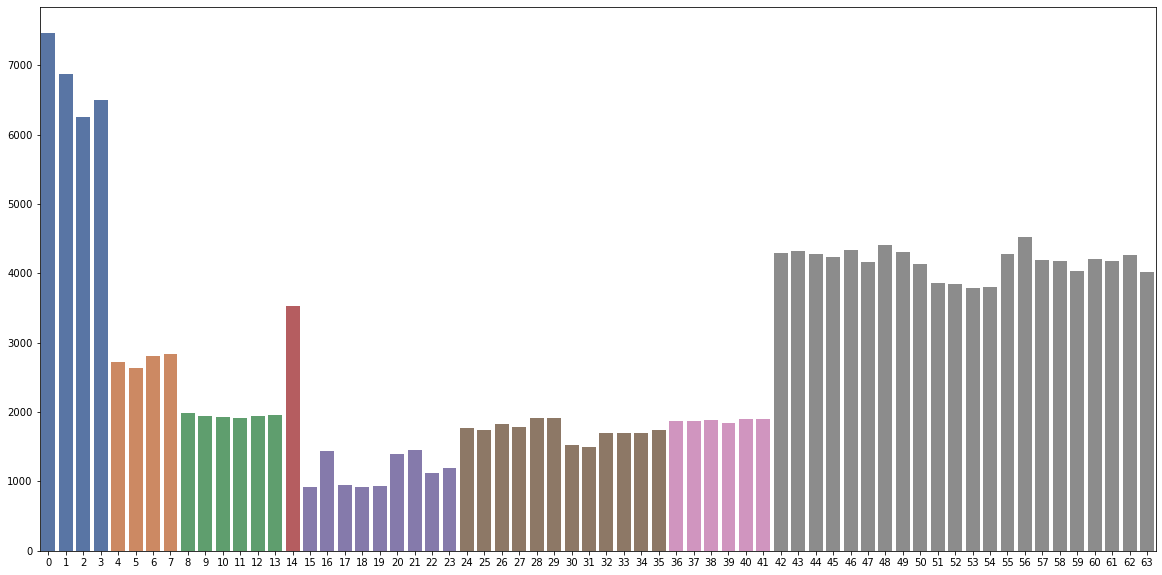

In [8]:
plt.figure(figsize=(20,10))

cols = hela_meta.PXD_accession.apply(lambda x: lut[x])

sns.barplot(x=list(range(len(hela_nsaf))), y=hela_nsaf.notna().sum(axis=1), palette=cols)

In [31]:
logged_hela_nsaf = np.log2(hela_nsaf)

In [9]:
reoccurring, deleted = AAF._identify_global_reoccured_proteins(hela_nsaf.fillna(0), .7)

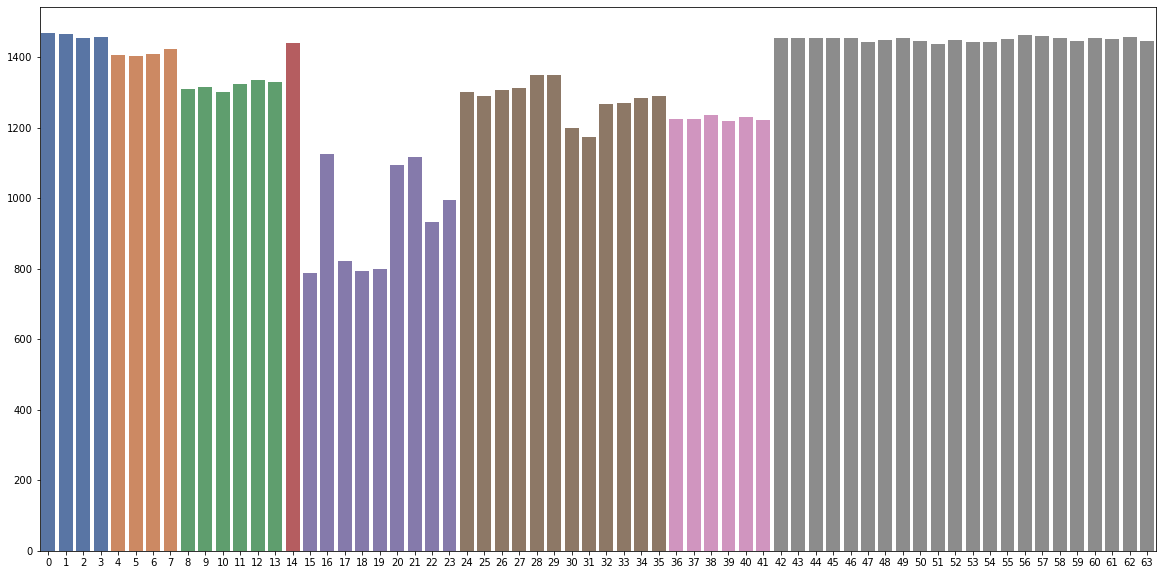

In [33]:
filtered_hela_nsaf = hela_nsaf.loc[:,reoccurring]
filtered_log_hela_nsaf = logged_hela_nsaf.loc[:,reoccurring]

plt.figure(figsize=(20,10))

sns.barplot(x=list(range(len(hela_nsaf))), y=filtered_hela_nsaf.notna().sum(axis=1), palette=cols)

In [11]:
hela_meta.PXD_accession.unique()

array(['PXD004452', 'PXD004182', 'PXD004940', 'PXD001441', 'PXD003530',
       'PXD006112', 'PXD004900', 'PXD000612'], dtype=object)

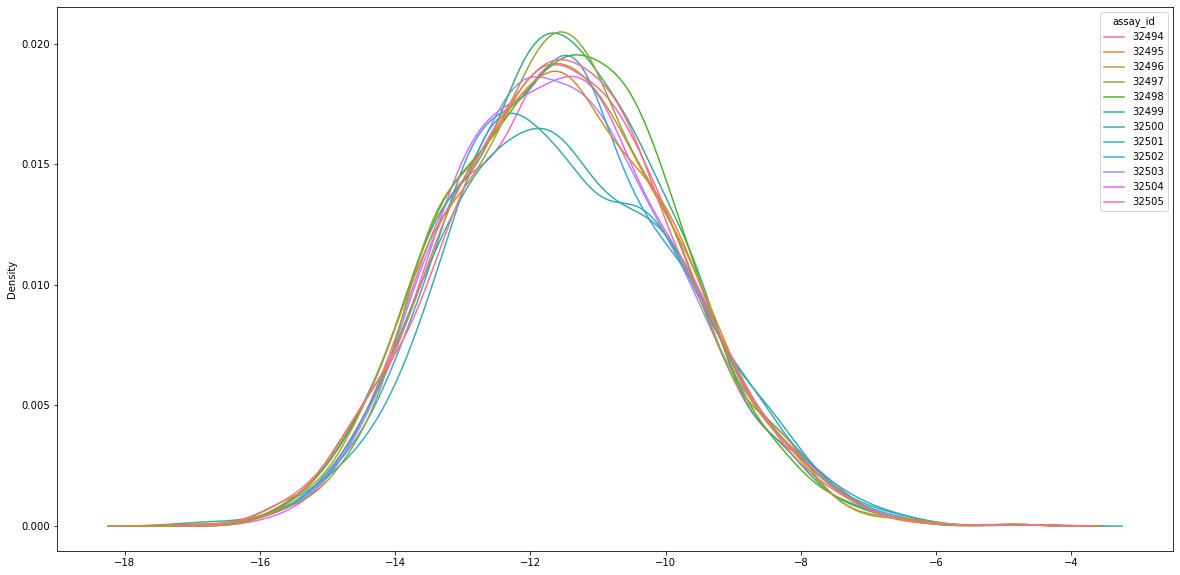

In [28]:
# Plotting the abundance values
plt.figure(figsize=(20,10))
sns.kdeplot(data=np.log2(filtered_hela_nsaf.loc[hela_meta[hela_meta.PXD_accession == "PXD006112"].index,:]).transpose())

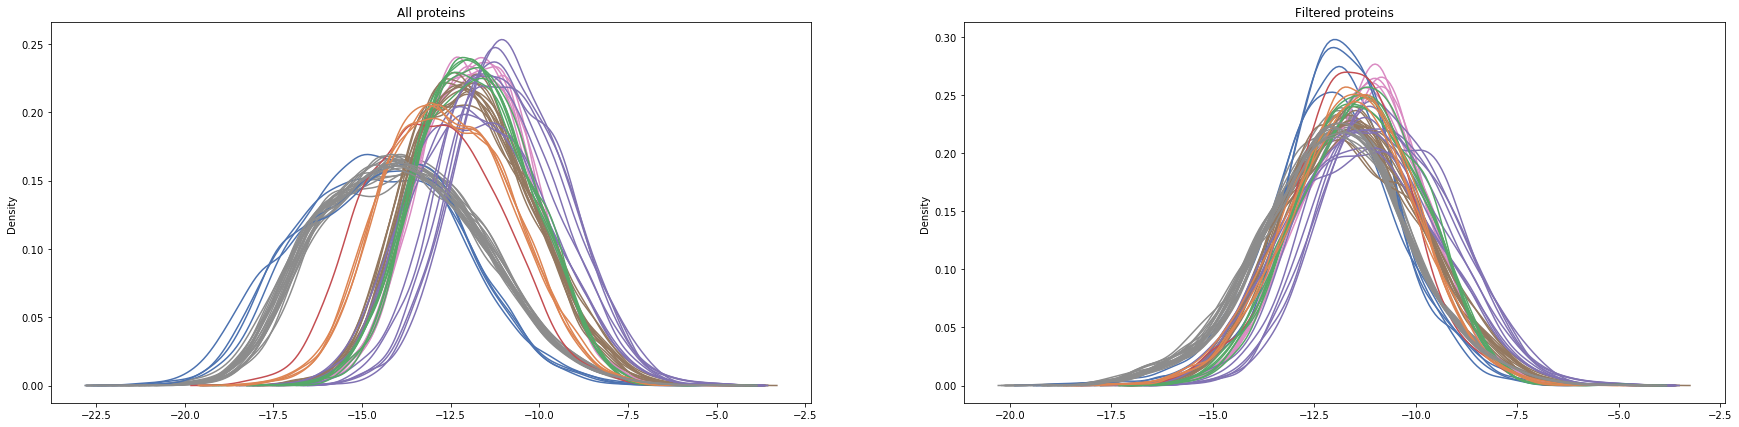

In [61]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=logged_hela_nsaf.transpose(), palette = list(hela_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=filtered_log_hela_nsaf.transpose(), palette = list(hela_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[1])

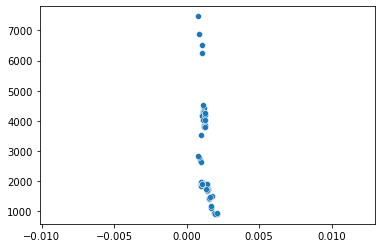

In [35]:
sns.scatterplot(x=filtered_hela_nsaf.iloc[:,:].transpose().std(), y=list(hela_nsaf.notna().sum(axis=1)))

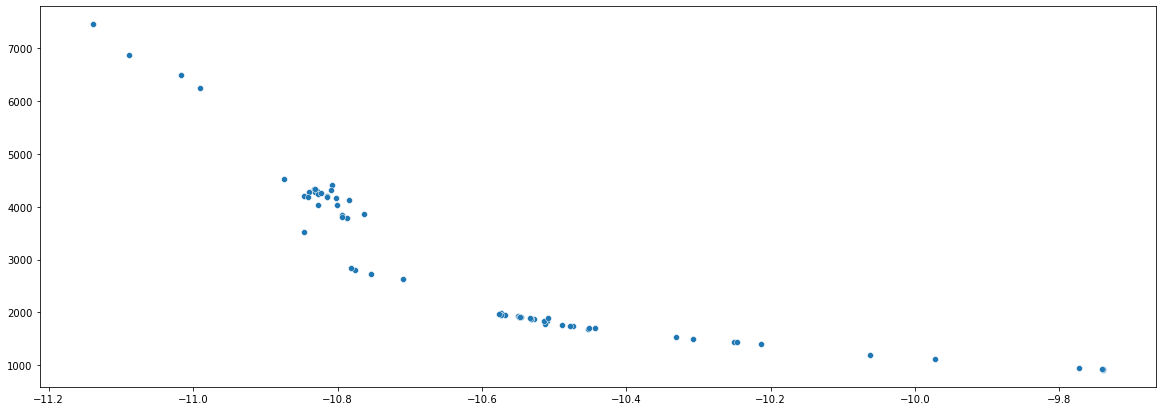

In [36]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log2(list(filtered_hela_nsaf.iloc[:,:].mean(axis=1))), y=list(hela_nsaf.notna().sum(axis=1)))

32546:	common prots: 1440	medianFC: 0.1812422808852232	stdFC: 0.6462659125912251
32616:	common prots: 1437	medianFC: 0.1943711173074251	stdFC: 0.6605388173412713
34748:	common prots: 1428	medianFC: 0.2561035523598183	stdFC: 0.827138708208917
34786:	common prots: 1435	medianFC: 0.19090651461343672	stdFC: 0.6996003712539893
32355:	common prots: 1383	medianFC: -0.009583368024380949	stdFC: 0.6757305971269729
32356:	common prots: 1381	medianFC: -0.0005096289737997437	stdFC: 0.6689411350413323
32357:	common prots: 1388	medianFC: -0.016997319235568544	stdFC: 0.6501987372914839
32358:	common prots: 1403	medianFC: -0.025866562325485846	stdFC: 0.6332293704480445
32374:	common prots: 1288	medianFC: -0.11089099506712621	stdFC: 0.75594561688425
32375:	common prots: 1291	medianFC: -0.16724532795047797	stdFC: 0.7557869492289984
32376:	common prots: 1279	medianFC: -0.14580202386695645	stdFC: 0.7584551937749556
32377:	common prots: 1299	medianFC: -0.09503971656004773	stdFC: 0.7692022211102065
32378:	co

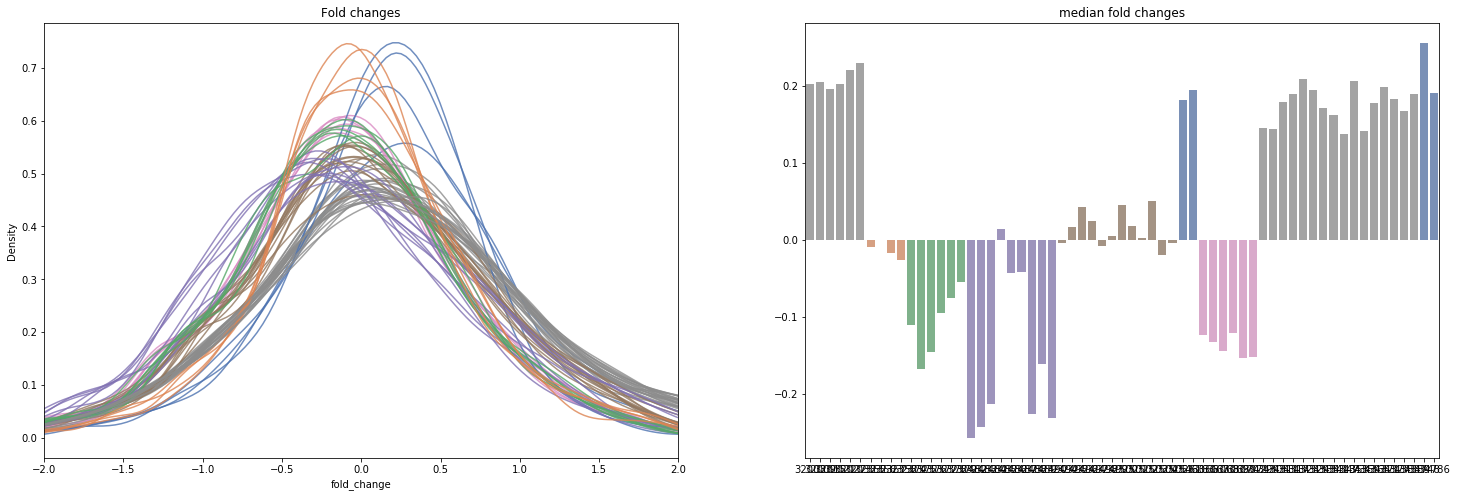

In [64]:
plot_fc(filtered_hela_nsaf.fillna(0.0), ref = 32416, plot_med_fc = True, color_scheme=list(cols_[~cols_.index.isin([32416])]))

2 aspects can be appreciated:
1. Systematic differences in the quantification levels are visible
2. Consequently, the median fold change between proteins of the HeLa samples are shifted

Possibly, this could be corrected by subtracting the median NSAF value to every protein in the sample and dividing by the standard deviation

In [108]:
med_std = pd.DataFrame()

def scale_sample(row):
    median, std = med_std.loc[row.name,:]
    return (row-median)/std

med_std['median'] = np.log2(filtered_hela_nsaf).fillna(0).apply(lambda x: calc_median(x), axis =1)
med_std['std'] = np.log2(filtered_hela_nsaf).apply(lambda x: np.std(x), axis =1)

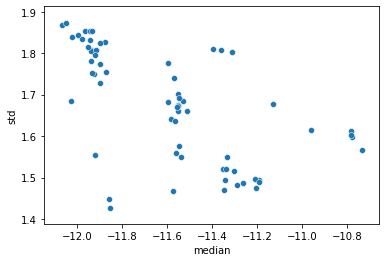

In [109]:
sns.scatterplot(data=med_std, x='median', y="std")

In [115]:
scaled_hela_nsaf = logged_hela_nsaf.apply(lambda x: scale_sample(x), axis = 1)

In [116]:
filtered_scaled_hela_nsaf = scaled_hela_nsaf.loc[:,reoccurring]

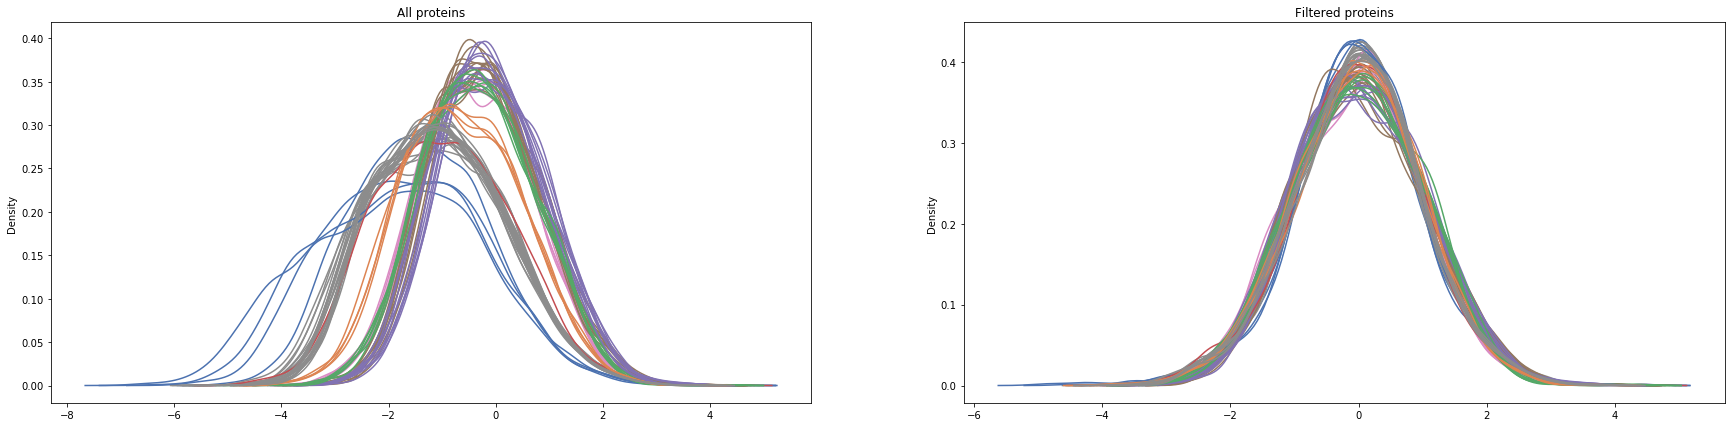

In [117]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=scaled_hela_nsaf.transpose(), palette = list(hela_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=filtered_scaled_hela_nsaf.transpose(), palette = list(hela_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[1])

32546:	common prots: 1440	medianFC: -0.011722562254870256	stdFC: 0.4455814869246404
32616:	common prots: 1437	medianFC: -0.006895454060074053	stdFC: 0.4528305691087597
34748:	common prots: 1428	medianFC: -0.02075533391622332	stdFC: 0.5172890054658039
34786:	common prots: 1435	medianFC: -0.01820529999632745	stdFC: 0.46191247609111113
32355:	common prots: 1383	medianFC: 0.02057661238876605	stdFC: 0.44112480115802977
32356:	common prots: 1381	medianFC: 0.022739518856764968	stdFC: 0.42240476834581975
32357:	common prots: 1388	medianFC: 0.01611335318750732	stdFC: 0.4264410690170659
32358:	common prots: 1403	medianFC: -0.004077832196542157	stdFC: 0.41830864535146095
32374:	common prots: 1288	medianFC: 0.033324848642293445	stdFC: 0.5144281668685983
32375:	common prots: 1291	medianFC: 0.025407217445253722	stdFC: 0.512117695010626
32376:	common prots: 1279	medianFC: 0.020654523487156493	stdFC: 0.5119936405901971
32377:	common prots: 1299	medianFC: 0.04600857527002541	stdFC: 0.5079937849580763
3

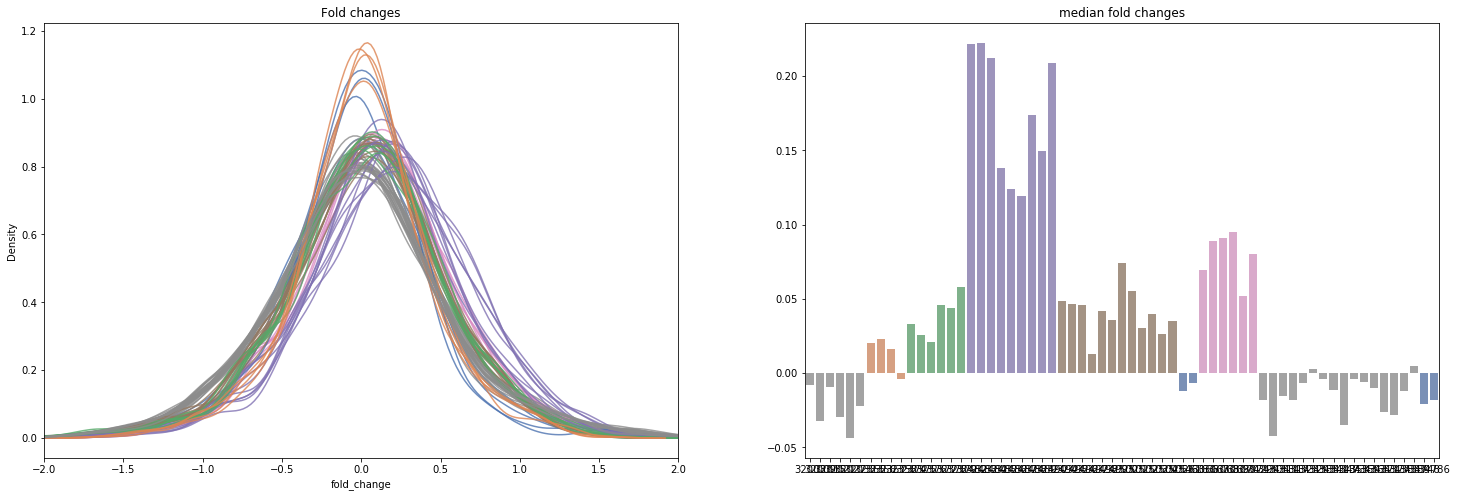

In [128]:
plot_fc(np.exp2(filtered_scaled_hela_nsaf).fillna(0.0), ref = 32416, plot_med_fc = True, color_scheme=list(cols_[~cols_.index.isin([32416])]))

PXD003530 still shows systematic differences where the median protein fold change difference is .2

In [131]:
hela_meta[hela_meta.PXD_accession == "PXD003530"]

,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,all_PSM,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id,ionbot_version
assay_id,,,,,,,,,,,,,,,,,,,
32482,1868,20120227_MT_01,578,HeLa,adenocarcinoma,/,cervix,/,NaN,PXD003530,76080,14023,3950,956,in-solution,Q-exactive,27913581,0,IONBOT_v0.7.0
32487,1868,20120302_MT_DMSO_load_2uL_4h_G6,578,HeLa,adenocarcinoma,/,cervix,/,NaN,PXD003530,185179,30523,9026,1490,in-solution,Q-exactive,27913581,0,IONBOT_v0.7.0
32490,1868,20120306_MT_DMSO_load_2h_G6,578,HeLa,adenocarcinoma,/,cervix,/,NaN,PXD003530,89830,13911,4074,991,in-solution,Q-exactive,27913581,0,IONBOT_v0.7.0
32483,1868,20120227_MT_02,621,HeLa,adenocarcinoma,aspirin,cervix,/,NaN,PXD003530,75047,13831,3926,949,in-solution,Q-exactive,27913581,0,IONBOT_v0.7.0
32484,1868,20120227_MT_03,621,HeLa,adenocarcinoma,aspirin,cervix,/,NaN,PXD003530,77654,14427,4088,962,in-solution,Q-exactive,27913581,0,IONBOT_v0.7.0
32485,1868,20120302_MT_AspD0_load_2uL_4h_G6,621,HeLa,adenocarcinoma,aspirin,cervix,/,NaN,PXD003530,179791,29606,8669,1468,in-solution,Q-exactive,27913581,0,IONBOT_v0.7.0
32486,1868,20120302_MT_AspD3_load_2uL_4h_G6,621,HeLa,adenocarcinoma,aspirin,cervix,/,NaN,PXD003530,189333,31528,9170,1501,in-solution,Q-exactive,27913581,0,IONBOT_v0.7.0
32488,1868,20120306_MT_AspD0_load_2h_G6,621,HeLa,adenocarcinoma,aspirin,cervix,/,NaN,PXD003530,106417,17108,5027,1168,in-solution,Q-exactive,27913581,0,IONBOT_v0.7.0
32489,1868,20120306_MT_AspD3_load_2h_G6,621,HeLa,adenocarcinoma,aspirin,cervix,/,NaN,PXD003530,113610,18300,5371,1229,in-solution,Q-exactive,27913581,0,IONBOT_v0.7.0


# Apply this workflow to MCF7 subset

In [144]:
len(cols)

43

Plot the identified proteins per sample. Projects are colored

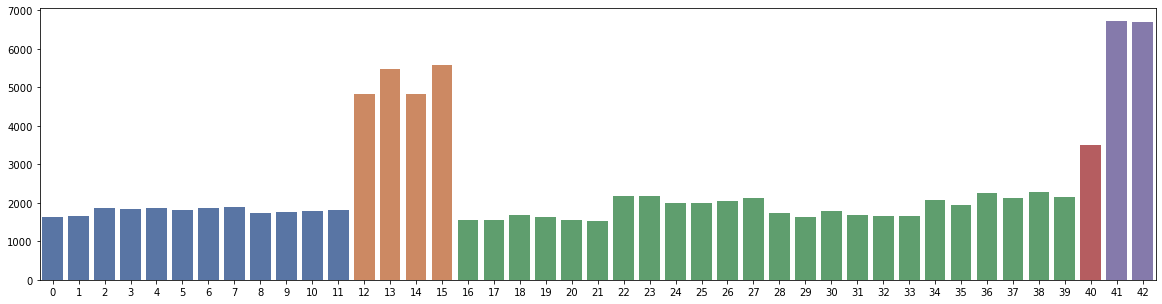

In [12]:
MCF7_assays = meta[meta.cell_line == "MCF7"].index

MCF7_nsaf = nsaf.loc[MCF7_assays,:]
MCF7_meta = meta[meta.index.isin(MCF7_assays)]

lut = {}
for x in MCF7_meta.PXD_accession.unique():
    lut[x] = sns.color_palette("deep")[len(lut)]

plt.figure(figsize=(20,5))

cols = MCF7_meta.PXD_accession.apply(lambda x: lut[x])

sns.barplot(x=list(range(len(MCF7_nsaf))), y=MCF7_nsaf.notna().sum(axis=1), palette=cols)

After filtering 50 % of the reoccuring proteins

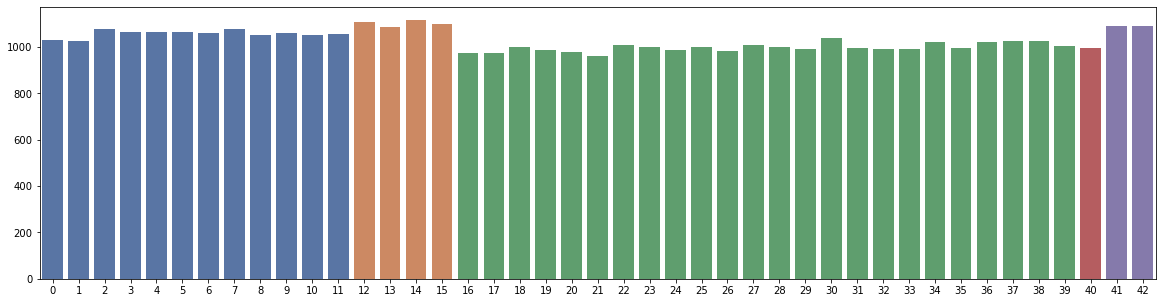

In [13]:
logged_MCF7_nsaf = np.log2(MCF7_nsaf)
reoccurring, deleted = AAF._identify_global_reoccured_proteins(MCF7_nsaf.fillna(0), .7)

filtered_MCF7_nsaf = MCF7_nsaf.loc[:,reoccurring]
filtered_log_MCF7_nsaf = logged_MCF7_nsaf.loc[:,reoccurring]

plt.figure(figsize=(20,5))

sns.barplot(x=list(range(len(MCF7_nsaf))), y=filtered_MCF7_nsaf.notna().sum(axis=1), palette=cols)

Plot the abundance values of proteins, where each line is the distribution of protein expression values for a sample, colored by project. <br>
This is done for all proteins and for the filtered proteins only.

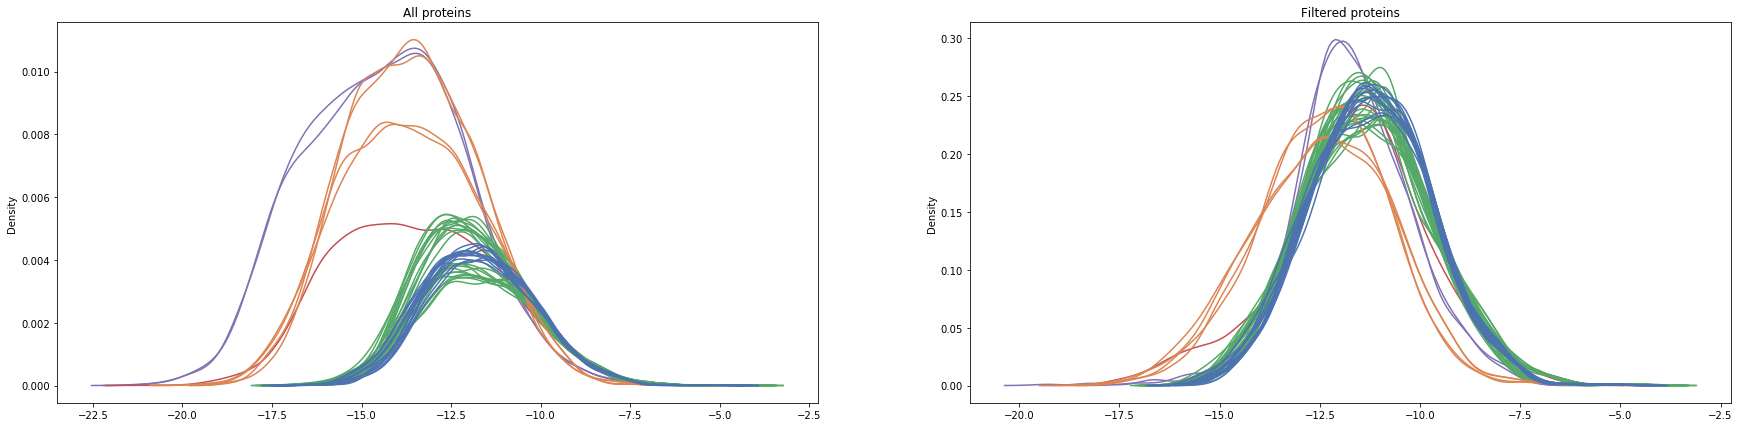

In [14]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=logged_MCF7_nsaf.transpose(), palette = list(MCF7_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=filtered_log_MCF7_nsaf.transpose(), palette = list(MCF7_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[1])

Plot the distribution of fold changes of protein expression between a reference sample and all the other samples

31254:	common prots: 896	medianFC: -0.12488546567113215	stdFC: 1.0806683122309946
31255:	common prots: 889	medianFC: -0.146388480131081	stdFC: 1.0865722275266143
31256:	common prots: 935	medianFC: -0.16982737329713124	stdFC: 1.088271321527415
31257:	common prots: 925	medianFC: -0.13430652828480666	stdFC: 1.0875758541957643
31258:	common prots: 925	medianFC: -0.13786067961468254	stdFC: 1.0775700657744076
31259:	common prots: 924	medianFC: -0.1303370156505591	stdFC: 1.0645979701175163
31260:	common prots: 920	medianFC: -0.10015686530896763	stdFC: 1.062781911426414
31261:	common prots: 937	medianFC: -0.08491117838992368	stdFC: 1.0794427342591524
31262:	common prots: 915	medianFC: -0.10994472660038761	stdFC: 1.087492482973802
31263:	common prots: 922	medianFC: -0.10462206882030815	stdFC: 1.084235003744822
31264:	common prots: 915	medianFC: -0.16246852321115973	stdFC: 1.0840475826594984
31265:	common prots: 917	medianFC: -0.15298828336462922	stdFC: 1.0969670898985546
31353:	common prots: 96

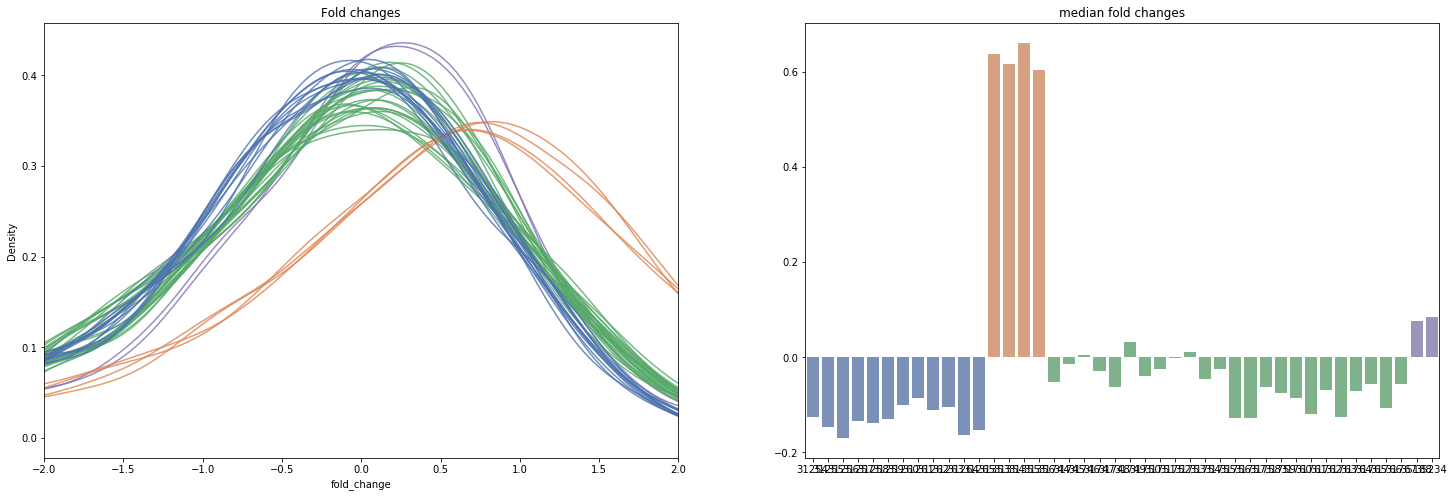

In [17]:
plot_fc(filtered_MCF7_nsaf.fillna(0.0), ref = 33989, plot_med_fc = True, color_scheme=list(cols[~cols.index.isin([33989])]))

You see systematic project bias

In [20]:
med_std = pd.DataFrame()

def calc_median(row):
    values = row[row!=0]
    return np.median(values)

med_std['median'] = np.log2(filtered_MCF7_nsaf).fillna(0).apply(lambda x: calc_median(x), axis =1)
med_std['std'] = np.log2(filtered_MCF7_nsaf).apply(lambda x: np.std(x), axis =1)

scaled_MCF7_nsaf = logged_MCF7_nsaf.apply(lambda x: scale_sample(x), axis = 1)
filtered_scaled_MCF7_nsaf = scaled_MCF7_nsaf.loc[:,reoccurring]

Plot the same stuff, after median centering with variance correction

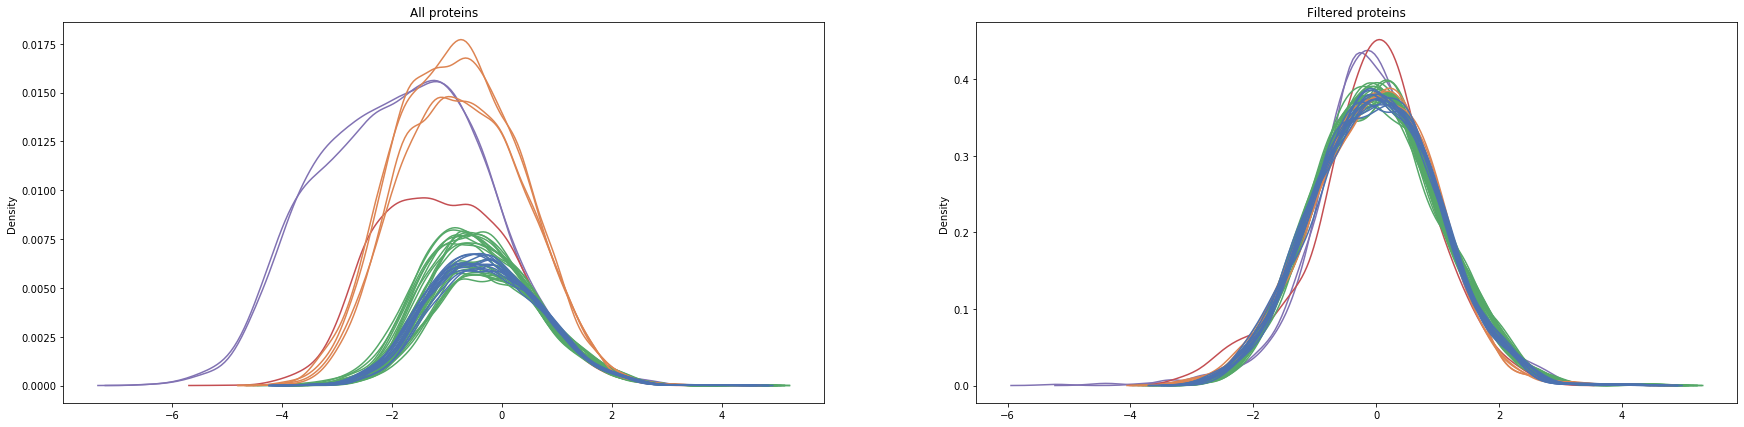

In [21]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=scaled_MCF7_nsaf.transpose(), palette = list(MCF7_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=filtered_scaled_MCF7_nsaf.transpose(), palette = list(MCF7_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[1])

31254:	common prots: 896	medianFC: 0.025455468480618068	stdFC: 0.6338265003072292
31255:	common prots: 889	medianFC: 0.010874549579013628	stdFC: 0.6350600779522321
31256:	common prots: 935	medianFC: 0.012209796138195964	stdFC: 0.6354769594712956
31257:	common prots: 925	medianFC: -0.000358598907739058	stdFC: 0.6336537102658923
31258:	common prots: 925	medianFC: 0.008423754395079362	stdFC: 0.6272167948921257
31259:	common prots: 924	medianFC: 0.014529206546349132	stdFC: 0.6221508784291514
31260:	common prots: 920	medianFC: 0.06597034634988871	stdFC: 0.6134096578104653
31261:	common prots: 937	medianFC: 0.05100837359634769	stdFC: 0.6225803686410982
31262:	common prots: 915	medianFC: 0.041315376620581885	stdFC: 0.639089457903402
31263:	common prots: 922	medianFC: 0.05148662029689543	stdFC: 0.6393392797187576
31264:	common prots: 915	medianFC: -0.007194391540999319	stdFC: 0.636438416082271
31265:	common prots: 917	medianFC: -0.02833854629007258	stdFC: 0.6430214022687626
31353:	common prots

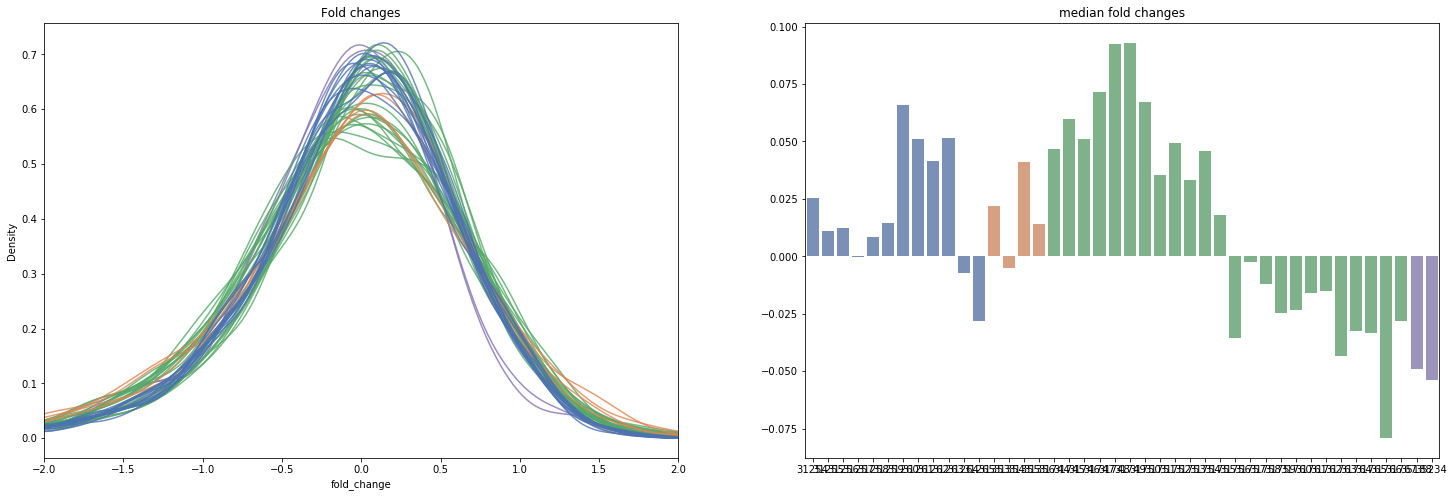

In [22]:
plot_fc(np.exp2(filtered_scaled_MCF7_nsaf).fillna(0.0), ref = 33989, plot_med_fc = True, color_scheme=list(cols[~cols.index.isin([33989])]))

In [23]:
plot_fc(np.exp2(pd.concat([scaled_MCF7_nsaf, scaled_hela_nsaf])).fillna(0.0), ref=33989 ,plot_med_fc = True)

NameError: name 'scaled_hela_nsaf' is not defined

The corrected NSAF values for MCF7 and HeLa are appended and visualized in the same manner.

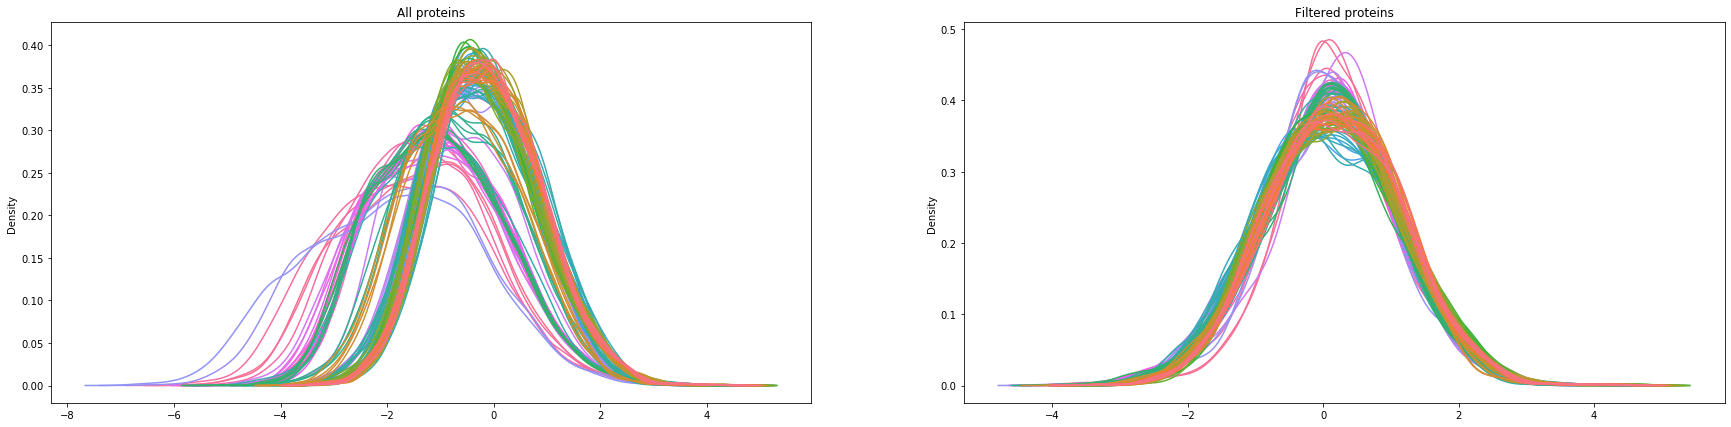

In [168]:
fig, ax = plt.subplots(1,2,figsize=(30,7))

mcf7_hela_set = pd.concat([scaled_MCF7_nsaf, scaled_hela_nsaf])


ax[0].set_title('All proteins')
sns.kdeplot(data=mcf7_hela_set.transpose(), legend = False, common_norm=False, ax =ax[0])


reoccurring, deleted = AAF._identify_global_reoccured_proteins(mcf7_hela_set.fillna(0), .7)

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=mcf7_hela_set.loc[:,reoccurring].transpose(), legend = False, common_norm=False, ax =ax[1])

Idea for future plots:

The reoccuring proteins should be the ones that are in the most abundant quantiles of protein expression. So, plot the quantile of the proteins that are selected, where the y-axis is the number of proteins originally quantified.

# Apply the correction to the complete dataset

## Define which assays to drop as outliers

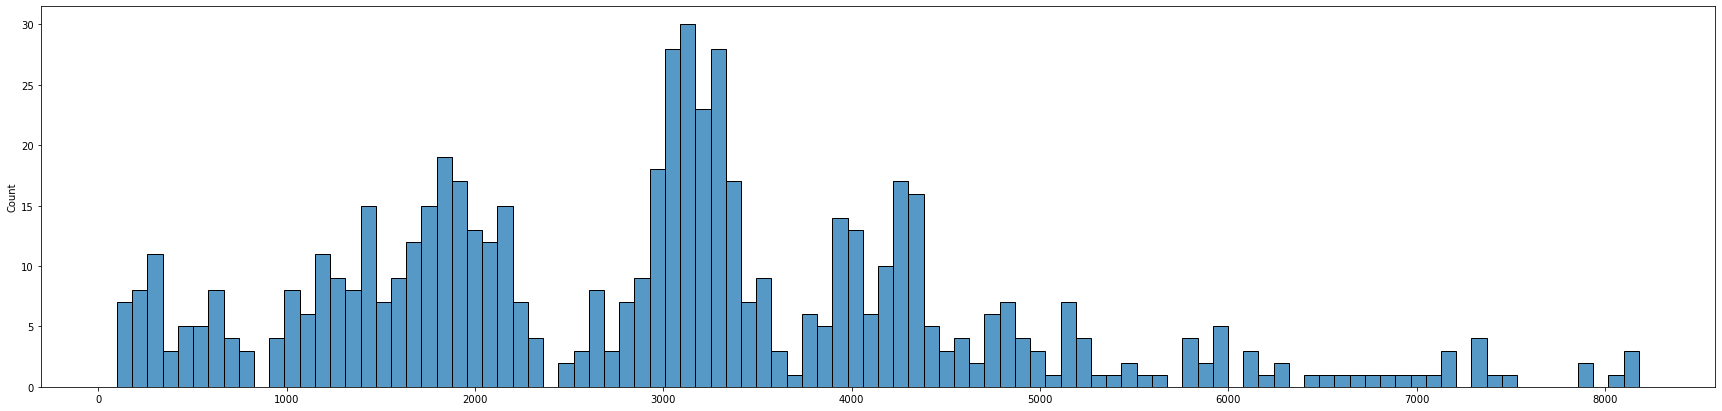

In [9]:
plt.figure(figsize=(30,7))
sns.histplot(nsaf.notna().sum(axis = 1), bins = 100)

Assays with <1000 protein identifications will not represent a large enough proteome proportion

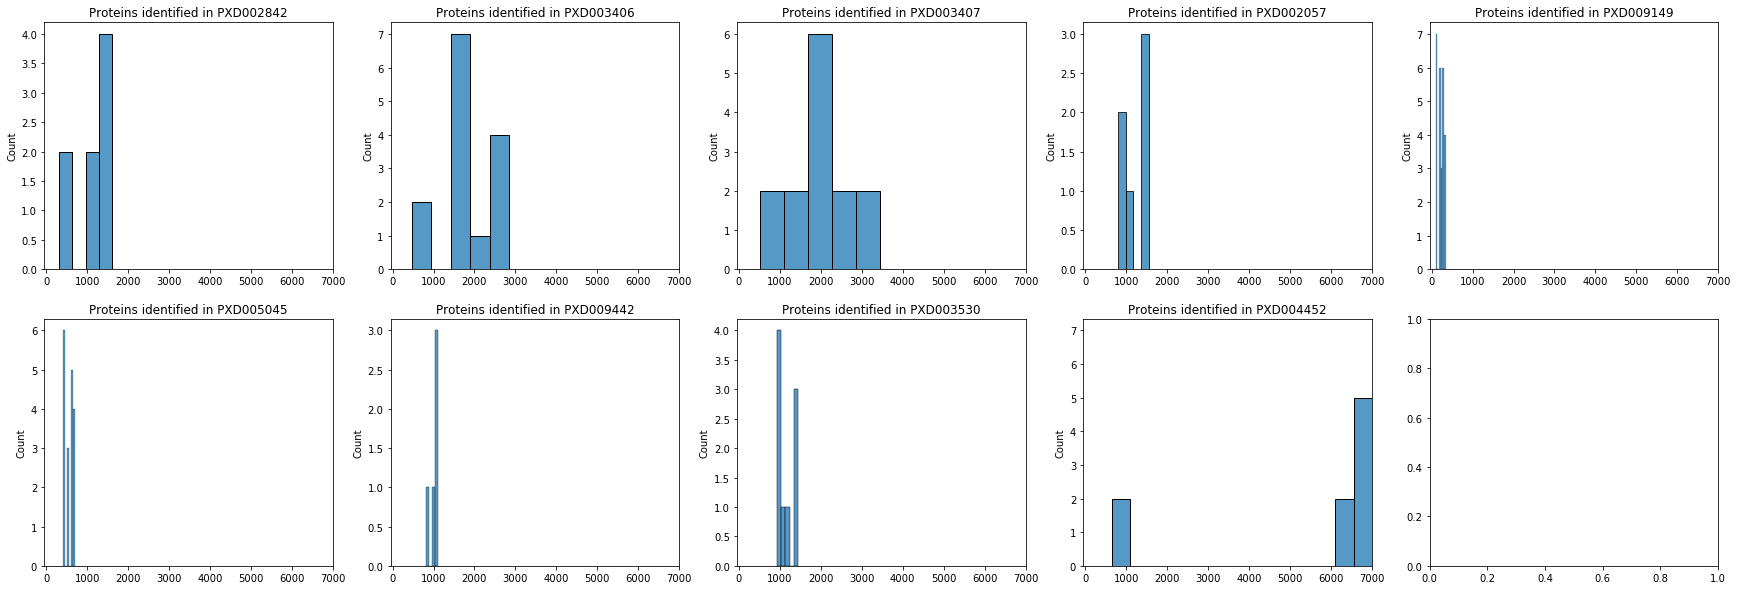

In [31]:
fig, ax = plt.subplots(2,5, figsize= (30,10))
for y, pxd in enumerate(meta.loc[nsaf.index[nsaf.notna().sum(axis=1) <1000], :].PXD_accession.unique()):
    
    if y < 5: 
        x=0
    else:
        y-=5
        x=1
    ax[x,y].set_title(f"Proteins identified in {pxd}")
    ax[x,y].set_xlim(left=-50, right=7000)
    sns.histplot(nsaf.loc[meta.PXD_accession == pxd].notna().sum(axis=1), ax=ax[x,y])

- **PXD002842**: Reported 3721 protein identifications. Here, only 312-1612 protein identifications were found with ionbot_v0.6.2 from 152,961 - 227,169 PSMs (sign_PSM: 31800). Drop the ones <1100
- **PXD003406, PXD003407**: Reported 8370 protein identifications. Here 4800 unique protein identifications were done. Assays reporting < 1100 proteins are dropped. Mean PSMs: 120,000 (sign_PSM: 21000). (ionbot_v0.6.2)
- **PXD002057**: Reported 800 protein identifications. Drop the AZD8931 resistant SKBR3 cells which all have <1100 protein identifications. sign_PSMs: 7500-9000. ionbot_version: v0.8.0
- **PXD009149**: Reported 3377 shared proteins (75% of total --> 4502 total proteins). ionbot_V0.6.0.2 never reaches more than 400 proteins with average sign_PSM: 843. Drop all of them
- **PXD005045**: Reported 1557 total protein identifications. We identify 1352 with ionbotv0.6.2. Average PSM (48398) with avg sign_PSM: 7897. No sample identified >700 proteins. Drop all of them.
- **PXD009442**: Reported +-2000 protein identifications per sample, however, only 1 proteotypic peptide was used to identify a protein. Here, >2 are needed and resulted in +- 1000 protein identifications per sample. Avg sign_PSM: 13311 (ionbotV0.6.2). Only keep the untreated cell. (assay_id 31702 with 1119 protein identifications)
- **PXD003530**: From 190,000-77,000 PSMs, (30,000-15,000 sign_PSM), only 950-1500 proteins were identified were >800 were identified in all samples. Keep only the ones with >1100 identifications.
- **PXD004452**: Only 2 assays identified <1100 proteins. For these, fractions are probably missing as most other identified >6000 proteins. Drop them.

In [13]:
low_id_rate = nsaf.loc[meta[meta.PXD_accession.isin("PXD002842 PXD003407 PXD003406 PXD002057 PXD009149 PXD005045 PXD009442 PXD003530 PXD004452".split())].index,:].notna().sum(axis=1)

drop_assays = low_id_rate.index[low_id_rate < 1100]

In [14]:
nsaf_filtered = nsaf.loc[~nsaf.index.isin(drop_assays)]

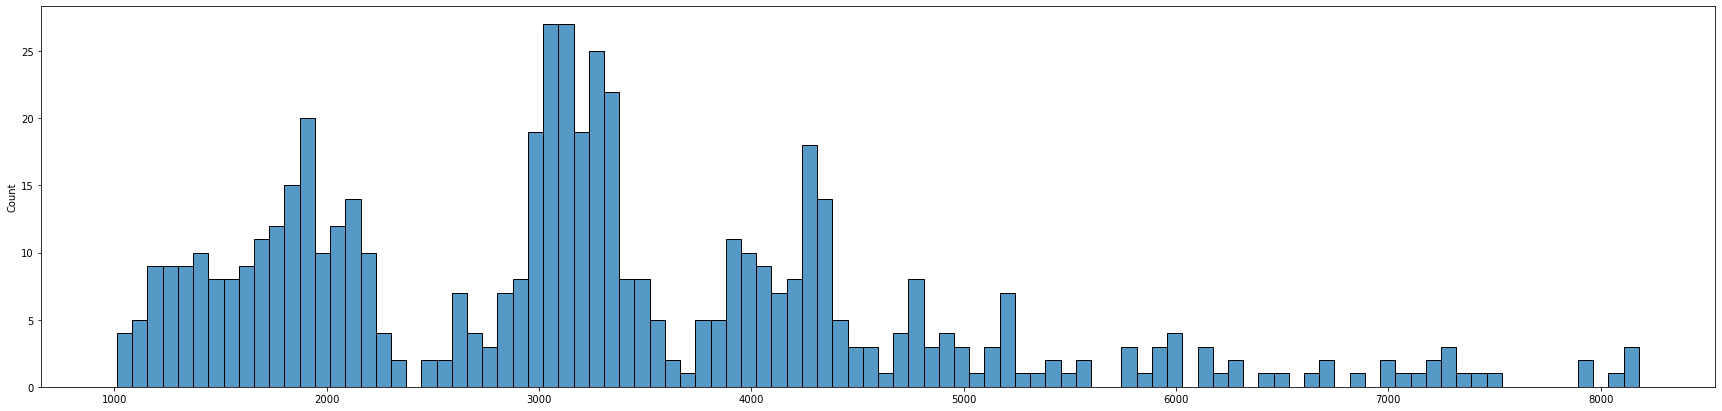

In [5]:
plt.figure(figsize=(30,7))
sns.histplot(nsaf_filtered.notna().sum(axis = 1), bins = 100)

## Show how sample amount per cell line

In [115]:
cell_tissue_map = {"cell_line":[], "tissue_type":[]}

for i, row in meta.loc[:,["cell_line", "tissue_type"]].iterrows():
    cell, tissue = row
    if cell not in cell_tissue_map["cell_line"]:
        cell_tissue_map["cell_line"].append(cell)
        cell_tissue_map["tissue_type"].append(tissue)
cell_tissue_map = pd.DataFrame(cell_tissue_map)

In [116]:
lut = {}
colors = sns.color_palette("deep") + sns.color_palette("bright")
for x in meta.tissue_type.unique():
    lut[x] = colors[len(lut)]

In [117]:
cols = [lut[cell_tissue_map[cell_tissue_map.cell_line==x].tissue_type.values[0]] for x in meta.cell_line.value_counts().index]

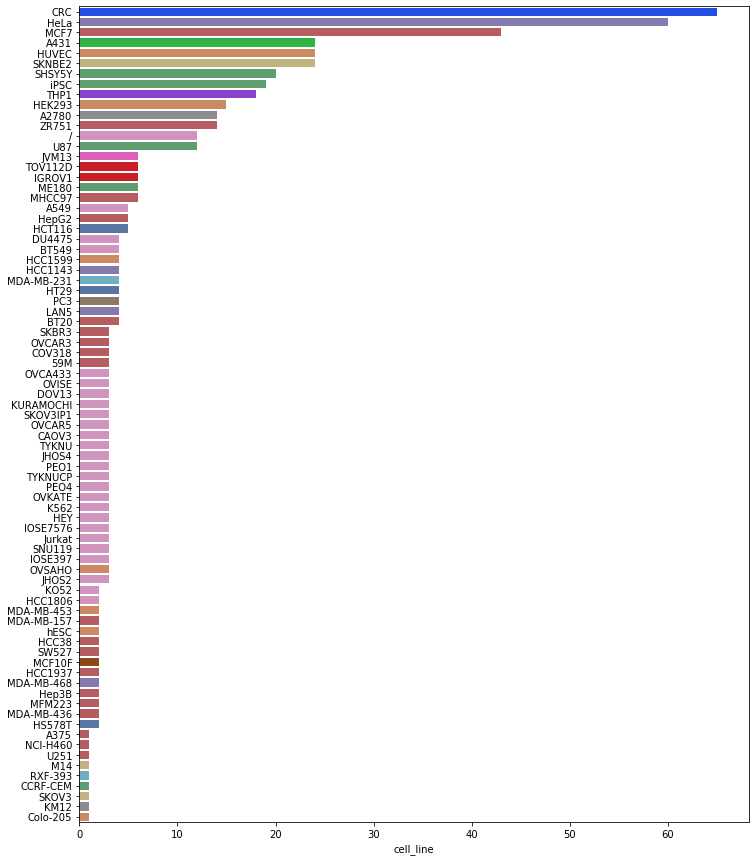

In [119]:
plt.figure(figsize=(12,15))
sns.barplot(x=meta[meta.index.isin(nsaf_filtered.index)].cell_line.value_counts(), y = meta[meta.index.isin(nsaf_filtered.index)].cell_line.value_counts().index, palette=cols)

## Apply median correction

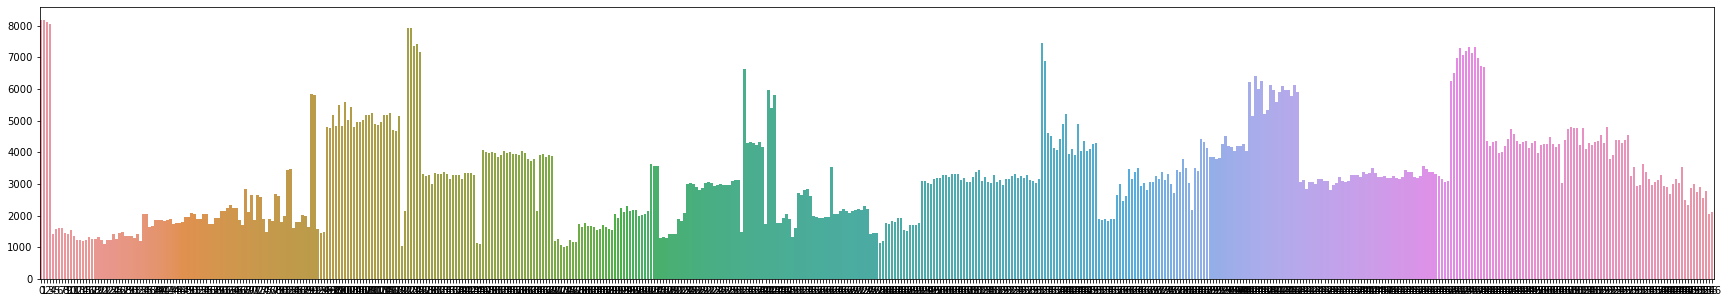

In [121]:
plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf_filtered))), y=nsaf_filtered.notna().sum(axis=1))

In [15]:
meta_filtered = meta[meta.index.isin(nsaf_filtered.index)]
print(meta_filtered.PXD_accession.nunique(), "projects and", meta_filtered.shape[0], "proteomes")

44 projects and 557 proteomes


In [16]:
reoccurring, deleted = AAF._identify_global_reoccured_proteins(nsaf_filtered.fillna(0), .7)

In [8]:
print(len(reoccurring))

1650


In [17]:
nsaf_filtered_reoccuring = nsaf_filtered.loc[:,reoccurring]

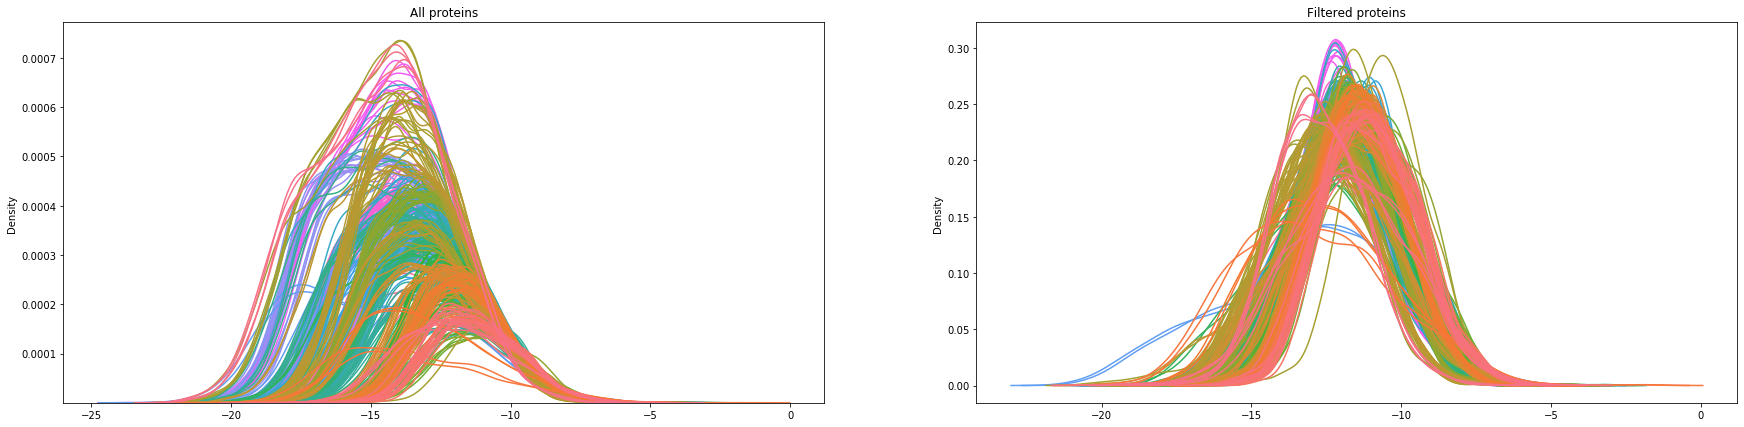

In [10]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=np.log2(nsaf_filtered).transpose(), legend = False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=np.log2(nsaf_filtered_reoccuring).transpose(), legend = False, common_norm=False, ax =ax[1])

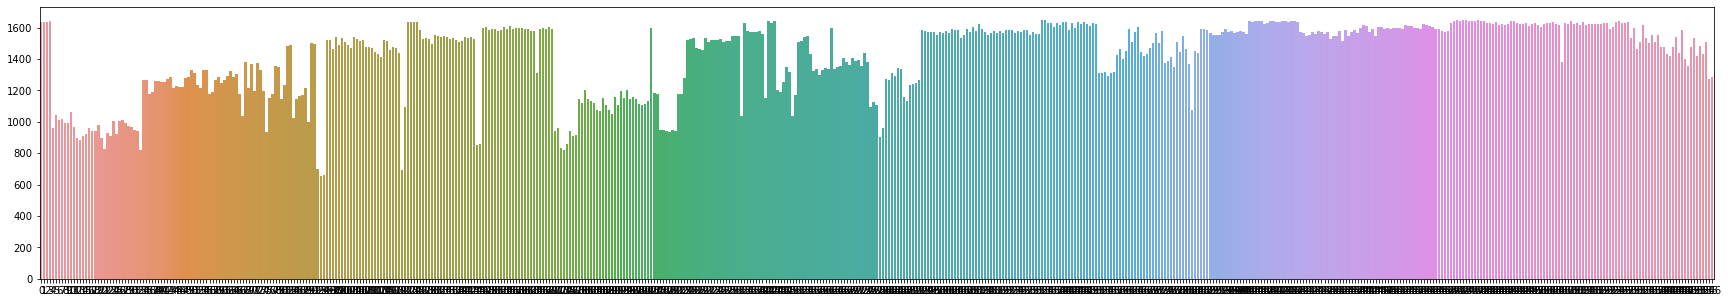

In [11]:
plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf_filtered_reoccuring))), y=nsaf_filtered_reoccuring.notna().sum(axis=1))

Median normalization is done as follows:
- log2 normalize expression data
- find reoccurring proteins for all samples
- define median and std for each sample based on the reoccurring proteins
- correct: (x-median)/std

In [18]:
# Log2 normalize
log_nsaf = np.log2(nsaf_filtered)

# Find reoccuring prots
reoccuring, deleted = AAF._identify_global_reoccured_proteins(nsaf_filtered.fillna(0), .7)
nsaf_reoccur = nsaf_filtered.loc[:, reoccurring]
log_nsaf_reoccur = log_nsaf.loc[:,reoccurring]

# Define median and std
med_std = pd.DataFrame()
med_std['median'] = log_nsaf_reoccur.fillna(0).apply(lambda x: calc_median(x), axis =1)
med_std['std'] = log_nsaf_reoccur.apply(lambda x: np.std(x), axis =1)

# Scale samples
def scale_sample(row):
    median, std = med_std.loc[row.name,:]
    return (row-median)/std

scaled_nsaf = log_nsaf.apply(lambda x: scale_sample(x), axis = 1)
scaled_nsaf_reoccur = scaled_nsaf.loc[:,reoccurring]

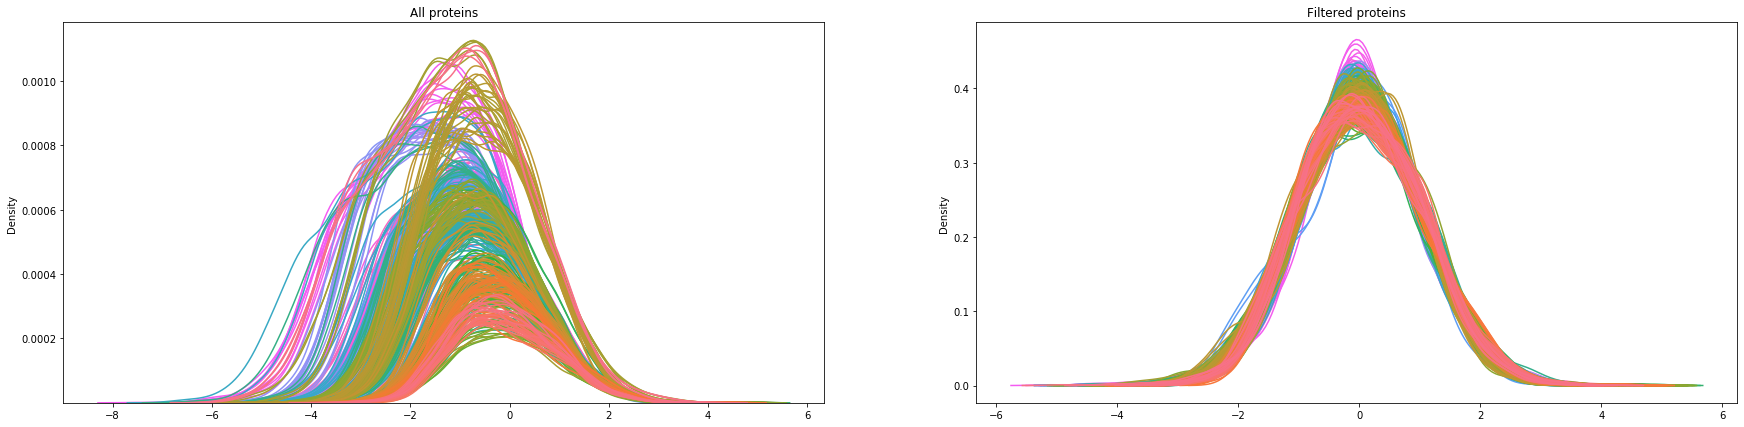

In [19]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=scaled_nsaf.transpose(), legend = False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=scaled_nsaf_reoccur.transpose(), legend = False, common_norm=False, ax =ax[1])

Save dataframe to csv for machine learning modelling

In [20]:
scaled_nsaf.to_csv("norm_NSAF_data.csv")

In [33]:
np.exp2(scaled_nsaf)

uniprot_id,A0A024RBG1,A0A075B6X5,A0A075B767,A0A087WV62,A0A087X0K7,A0A096LP01,A0A096LP49,A0A096LP55,A0A0A6YYK6,A0A0A6YYK7,...,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z5,Q9Y6Z7,W5XKT8
assay_id,,,,,,,,,,,,,,,,,,,,,
30960,0.197769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.258719,0.357554,0.439738,0.562651,NaN,0.690589,NaN,NaN,NaN,NaN
30961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.260966,0.389411,0.451230,0.469237,0.056926,0.621789,NaN,NaN,NaN,NaN
31008,0.189281,NaN,NaN,NaN,NaN,0.539949,NaN,NaN,NaN,NaN,...,NaN,0.145916,0.310703,0.450480,NaN,0.694543,0.309264,NaN,NaN,NaN
31009,0.187936,NaN,NaN,0.246789,NaN,0.636489,NaN,NaN,NaN,NaN,...,NaN,0.113596,0.387258,0.370894,NaN,0.617179,0.306897,NaN,NaN,NaN
31102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.298729,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.491478,1.168066,NaN,0.317706,NaN,NaN,NaN,NaN
36563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.352954,NaN,0.590305,0.293286,NaN,1.137719,NaN,NaN,NaN,NaN
36568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.337789,NaN,0.221910,0.402700,NaN,0.651617,NaN,NaN,NaN,NaN


In [50]:
scaled_nsaf.std().sort_values()

uniprot_id
Q96N22    0.015581
P56817    0.032592
Q6UXN7    0.046892
Q5T890    0.049258
B4DJY2    0.051560
            ...   
Q6ZQT7         NaN
Q86WV1         NaN
Q96F15         NaN
Q9H8W2         NaN
Q9UIV8         NaN
Length: 14507, dtype: float64

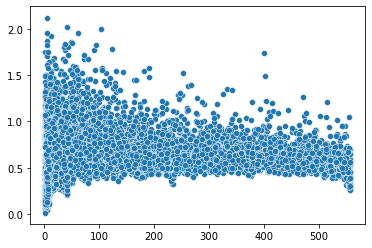

In [55]:
sns.scatterplot(x=scaled_nsaf.notna().sum(), y=scaled_nsaf.std())

In [68]:
abundant_prot = scaled_nsaf.columns[scaled_nsaf.notna().sum() > 300]

In [69]:
scaled_nsaf.loc[:,abundant_prot].std().sort_values()

uniprot_id
Q7KZF4    0.260177
P50991    0.264829
P54136    0.274509
P42704    0.280386
P49411    0.281835
            ...   
P16144    1.291023
Q02952    1.340168
P48681    1.352100
Q8IVF2    1.495873
Q14315    1.743404
Length: 2433, dtype: float64

Q7KZF4 has Tau specificity score of 0.11 in THPA <br>
P50991 0.05 <br>
Q99497 0.04

In [44]:
# DJ-1, yet only present in 41 of 557 samples
scaled_nsaf.loc[:,"Q99497"].std()

0.3312413575161818

---
---